# Setting up Imports and Connecting to AWS EC2 Instance

In [ ]:
# necessary installations for the first time 
!pip install tensorflow 
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
!pip install opencv-python


!pip install timm
!pip install transformers
!pip install albumentations
!pip install tensorflow
!pip install opencv-python-headless==4.5.2.52
!pip install nltk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Download and unzip dataset from scratch
# takes 20 minutes

! pip install kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c h-and-m-personalized-fashion-recommendations
! unzip -q h-and-m-personalized-fashion-recommendations.zip -d .

In [ ]:
import torch
import pandas as pd 
import numpy as np 
import os
import cv2
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
import albumentations as alb
from tqdm.autonotebook import tqdm
import itertools
import seaborn as sns
from numpy import savetxt, loadtxt

In [ ]:
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
available_gpus

# Data Configs


In [ ]:
class Config:
  # base = '/content/drive/MyDrive/CIS522_Project/'
  base = ''
  debug = False

  # we want batch size to be as big as possible for contrastive loss
  # OpenAI uses 32768 but we can only use 128 due to RAM constraints 
  batch_size = 128

  num_workers = 2
  head_lr = 1e-3
  image_encoder_lr = 1e-4
  text_encoder_lr = 1e-5

  # weight decay is .2 in CLIP Paper
  weight_decay = 0.2

  # we use a different LR, namely decrease on Plateau 
  # Decrease LR after 1 epoch with no improvement 
  patience = 1
  factor = 0.8

  # CLIP paper did 32 epochs
  # because of our compute we can only realistically do 10 epochs 
  # takes about 20 minutes per epoch using AWS EC2 p3.2xlarge instance
  # total runtime of about 4 hours to train the model 
  epochs = 8
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


  model_name = 'resnet50'
  image_embedding = 2048
  base_image_embedding = 64

  # original text encoder was transformer
  text_encoder_model = "distilbert-base-uncased"
  text_embedding = 768
  base_text_embedding = 300
  text_tokenizer = "distilbert-base-uncased"
  max_length = 50

  pretrained = True # for both image encoder and text encoder
  trainable = True # for both image encoder and text encoder
  temperature = 1.0

  # CLIP used 224, have to use 112 for computational advantages
  image_size = 112

  # for projection head; used for both image and text encoders
  num_projection_layers = 1
  projection_dim = 256 
  dropout = 0.3

# Loading and Feature Engineering Text Data for Clothing

In [ ]:
#customers = pd.read_csv(base + 'customers.csv')
#transactions = pd.read_csv(base + 'transactions_train.csv')
articles = pd.read_csv(Config.base + 'articles.csv')
articles = articles.set_index(['article_id'])
articles.loc[articles.index == 108775015, 'detail_desc']

article_id
108775015    Jersey top with narrow shoulder straps.
Name: detail_desc, dtype: object

In [ ]:
articles.head()

,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
article_id,,,,,,,,,,,,,,,,,,,,,
108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


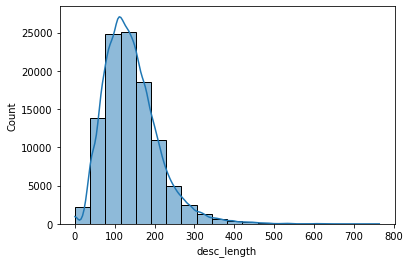

In [ ]:
def length(x):
  if type(x) == float:
    return 0 
  else:
    return len(x)

articles['desc_length'] = articles['detail_desc'].apply(length)
sns.histplot(articles, x='desc_length', bins=20, kde=True)

In [ ]:
articles.columns

Index(['product_code', 'prod_name', 'product_type_no', 'product_type_name',
       'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc', 'desc_length'],
      dtype='object')

In [ ]:
#Extract natural language columns
articles_nlp = articles[['prod_name','product_type_name','product_group_name','graphical_appearance_name','colour_group_name','perceived_colour_value_name','perceived_colour_master_name','department_name','index_name','index_group_name','section_name','garment_group_name', 'detail_desc']]

In [ ]:
articles_nlp.head()

,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc
article_id,,,,,,,,,,,,,
108775015,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
108775044,Strap top,Vest top,Garment Upper body,Solid,White,Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
108775051,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
110065001,OP T-shirt (Idro),Bra,Underwear,Solid,Black,Dark,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
110065002,OP T-shirt (Idro),Bra,Underwear,Solid,White,Light,White,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [ ]:
index_group_to_nlp = {'Ladieswear':"women", 'Baby/Children':'children', 'Menswear':'men', 'Sport':'sport', 'Divided':'all genders'}

In [ ]:
articles_nlp['index_group_name']=articles_nlp['index_group_name'].apply(lambda x: index_group_to_nlp[x])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
desc_format = "A picture of a {0}, a {12} It is a {1}, which is a {2} for {9}. It is {6} with a {5} pattern."
articles_nlp['long_description'] = [desc_format.format(*r) for r in articles_nlp.values.tolist()]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
articles_nlp["long_description"][108775015]

'A picture of a Strap top, a Jersey top with narrow shoulder straps. It is a Vest top, which is a Garment Upper body for women. It is Black with a Dark pattern.'

In [ ]:
articles["long_description"] = articles_nlp["long_description"]

# Zero Shot OpenAI CLIP - Alexander

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

In [ ]:
from PIL import Image
import clip
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm, trange
import time
from google.colab import files

In [ ]:
class CLIPDataset(torch.utils.data.Dataset):
  def __init__(self, root, preprocess):
    self.images, self.captions = make_dataset(root)
    self.preprocess = preprocess

  def __getitem__(self, index):
    img = self.images[index]
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = self.preprocess(Image.fromarray(img.astype(np.uint8)))

    return (img, self.captions[index])

  def __len__(self):
    return len(self.images)

In [ ]:
device = Config.device # If using GPU then use mixed precision training
model, preprocess = clip.load("ViT-B/32", device=device, jit=False) # Must set jit=False for training

dataset = CLIPDataset('/content/images/', preprocess)

train_size = int(0.9 * len(dataset))
val_size = int((len(dataset) - train_size)/2)
test_size = len(dataset) - train_size - val_size

print(f'train size: {train_size} val size: {val_size} test size: {test_size}')

# split full dataset into a training/val/test set with an 90/10/10 split
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
    )

train_loader = DataLoader(
    train_dataset,
    batch_size=Config.batch_size,
    num_workers=Config.num_workers,
    shuffle=True
    )

val_loader = DataLoader(
    val_dataset,
    batch_size=Config.batch_size,
    num_workers=Config.num_workers,
    shuffle=True
    )

test_loader = DataLoader(
    test_dataset,
    batch_size=Config.batch_size,
    num_workers=Config.num_workers,
    shuffle=True
    )

train size: 94590 val size: 5255 test size: 5255


In [ ]:
!nvidia-smi

Wed Apr 20 19:03:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    34W / 250W |   5077MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()

## Evaluation

In [ ]:
test_dataset.indices[:10]
test_dataset.dataset.captions

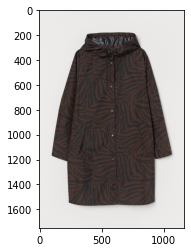

In [ ]:
img = Image.open(test_loader.dataset.dataset.images[66972])
plt.imshow(img)

In [ ]:
def get_accuracy(model, dataloader):
  total_correct = 0
  total = 0
  running_accuracy = []

  model.eval()
  for images, captions in tqdm(dataloader):
    with torch.no_grad():
      image_input = images.to(device)
      image_features = model.encode_image(image_input).float()
      text_tokens = clip.tokenize(captions, truncate=True).to(device)
      text_features = model.encode_text(text_tokens).float()
      
      image_features /= image_features.norm(dim=-1, keepdim=True)
      text_features /= text_features.norm(dim=-1, keepdim=True)
      similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
      
      _, indices = torch.max(torch.tensor(similarity), dim=0)
      total += len(images)
      ground_truth = torch.arange(len(images), dtype=torch.int, device='cpu')
      correct = len(images) - torch.count_nonzero(ground_truth - indices)
      total_correct += correct

      running_accuracy += [100*correct/len(images)]
  
  return 100*total_correct/total, running_accuracy

  0%|          | 0/42 [00:00<?, ?it/s]

Average accuracy: 60.475738525390625


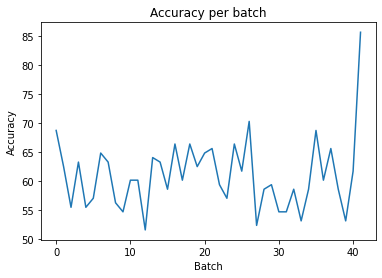

In [ ]:
avg_accuracy, acc_per_batch = get_accuracy(model, test_loader)
print(f'Average accuracy: {avg_accuracy}')
plt.plot(acc_per_batch)
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Accuracy per batch')
plt.show()

In [ ]:
def get_clip_image_embeddings(data, model):
  embeddings = []

  model.eval()

  # makes model weights non trainable
  with torch.no_grad():
    for images, captions in tqdm(data):
      # encode + project images 
      image_embeddings = model.encode_image(images.to(Config.device))
      # image_embeddings = model.image_projection(image_features)
      embeddings.append(image_embeddings)
  
  return torch.cat(embeddings)

In [ ]:
def find_clip_matches(model, image_features, image_filenames, query, n=1):

  # tokenize query 
    # tokenizer = DistilBertTokenizer.from_pretrained(Config.text_tokenizer)
    # encoded_query = tokenizer([query])
    # batch = {
    #     key: torch.tensor(values).to(Config.device)
    #     for key, values in encoded_query.items()
    # }
    with torch.no_grad():
        text_tokens = clip.tokenize(query, truncate=True).to(device)
        text_features = model.encode_text(text_tokens).float()
      # get text features + projection 
        # text_features = model.text_encoder(
        #     ids=batch["input_ids"], mask=batch["attention_mask"]
        # )
        # text_embeddings = model.text_projection(text_features)
    
    # use contrastive loss to find closest matches 
    # image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    # text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = torch.tensor(text_features.cpu().numpy() @ image_features.cpu().numpy().T)
    
    values, indices = torch.topk(similarity.squeeze(0), n)
    matches = [image_filenames[idx] for idx in indices]
    
    i = 1
    
    image = cv2.imread(matches[0])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f'Match: {i}')
    
    plt.show()

In [ ]:
image_embeddings = get_clip_image_embeddings(val_loader, model)

  0%|          | 0/42 [00:00<?, ?it/s]

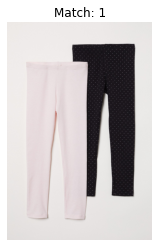

In [ ]:
find_clip_matches(model,
             image_embeddings,
             image_filenames=val_dataset.dataset.images,
             query='Blue jeans with rips',
             n=1)

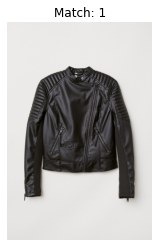

In [ ]:
find_clip_matches(model,
             image_embeddings,
             image_filenames=val_dataset.dataset.images,
             query='Green Hoodie with letters on front',
             n=1)

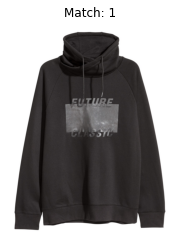

In [ ]:
find_clip_matches(model,
             image_embeddings,
             image_filenames=val_dataset.dataset.images,
             query='Short, green t-shirt with front pocket',
             n=1)

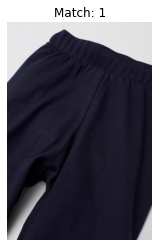

In [ ]:
find_clip_matches(model,
             image_embeddings,
             image_filenames=val_dataset.dataset.images,
             query='Short sleeved, white shirt',
             n=1)

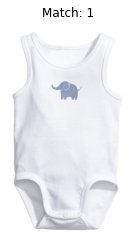

In [ ]:
find_clip_matches(model,
             image_embeddings,
             image_filenames=val_dataset.dataset.images,
             query='Long, brown, Fleece turtleneck',
             n=1)